In [53]:
%matplotlib inline
import sys, os
current_dir = os.getcwd()

import pandas as pd
import yaml
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt

import pcse
from pcse.fileinput import YAMLCropDataProvider, YAMLAgroManagementReader, ExcelWeatherDataProvider, CABOFileReader
from pcse.util import WOFOST72SiteDataProvider
from pcse.base import ParameterProvider
from pcse.models import Wofost72_WLP_FD

print("This notebook was built with:")
print("python version: %s " % sys.version)
print("PCSE version: %s" %  pcse.__version__)

This notebook was built with:
python version: 3.8.10 (default, Jun 22 2022, 20:18:18) 
[GCC 9.4.0] 
PCSE version: 5.5.3


# Defining Agromanagement

Implementing a crop rotation involves simulating two or more crops sequentially.

In [54]:
data_dir = os.path.join(os.getcwd(), 'farm_gym/envs/env_data/')
print(data_dir)

/home/tmrob2/PycharmProjects/farming-gym/farm_gym/envs/env_data/


In [55]:
crop_param_dir = os.path.join(data_dir, 'crop_params/')
cropd = YAMLCropDataProvider(crop_param_dir)

YAMLCropDataProvider - Failed to load cache file: [Errno 2] No such file or directory: 'barley'


In [56]:
cropd.set_active_crop("wheat", "Winter_wheat_101")
print(cropd)

YAMLCropDataProvider - current active crop 'wheat' with variety 'Winter_wheat_101'
Available crop parameters:
 {'CO2EFFTB': [40.0, 0.0, 360.0, 1.0, 720.0, 1.11, 1000.0, 1.11, 2000.0, 1.11], 'CO2TRATB': [40.0, 0.0, 360.0, 1.0, 720.0, 0.9, 1000.0, 0.9, 2000.0, 0.9], 'CO2AMAXTB': [40.0, 0.0, 360.0, 1.0, 720.0, 1.6, 1000.0, 1.9, 2000.0, 1.9], 'TBASEM': 0.0, 'TEFFMX': 30.0, 'TSUMEM': 120, 'IDSL': 2, 'DLO': 16.8, 'DLC': 8.0, 'TSUM1': 543, 'TSUM2': 1194, 'DTSMTB': [0.0, 0.0, 30.0, 30.0, 45.0, 30.0], 'DVSI': 0.0, 'DVSEND': 2.0, 'VERNBASE': 10.0, 'VERNSAT': 49.0, 'VERNDVS': 0.3, 'VERNRTB': [-8.0, 0.0, -4.0, 0.0, 3.0, 1.0, 10.0, 1.0, 17.0, 0.0, 20.0, 0.0], 'TDWI': 50.0, 'RGRLAI': 0.0082, 'SLATB': [0.0, 0.00212, 0.5, 0.00212, 2.0, 0.00212], 'SPA': 0.0, 'SSATB': [0.0, 0.0, 2.0, 0.0], 'SPAN': 31.3, 'TBASE': 0.0, 'KDIFTB': [0.0, 0.6, 2.0, 0.6], 'EFFTB': [0.0, 0.45, 40.0, 0.45], 'AMAXTB': [0.0, 35.83, 1.0, 35.83, 1.3, 35.83, 2.0, 4.48], 'TMPFTB': [0.0, 0.01, 10.0, 0.6, 15.0, 1.0, 25.0, 1.0, 35.0, 0.0

In [57]:
def get_weatherdataprovider(lat, long):
    location = (lat, long)
    return pcse.db.NASAPowerWeatherDataProvider(*location)
wdp = get_weatherdataprovider(-33.385300, 148.007904)
#wdp = get_weatherdataprovider(51.970, 5.670)
print(wdp)

Weather data provided by: NASAPowerWeatherDataProvider
--------Description---------
NASA/POWER CERES/MERRA2 Native Resolution Daily Data
----Site characteristics----
Elevation:  291.1
Latitude:  -33.385
Longitude: 148.008
Data available for 1984-01-01 - 2022-07-21
Number of missing days: 1



In [58]:
soilfile = os.path.join(data_dir, "SOILD", "ec3.soil")
soild = CABOFileReader(soilfile)

In [59]:
sited = WOFOST72SiteDataProvider(WAV=10)
params = ParameterProvider(cropdata=cropd, sitedata=sited, soildata=soild)

In [60]:
from pcse.fileinput import YAMLAgroManagementReader
agro_dir = os.path.join(os.getcwd(), "farm_gym/envs/env_data/agro/")
agromanagement_file = os.path.join(agro_dir, 'crop_rotation1.yaml')
agro = YAMLAgroManagementReader(agromanagement_file)
print(agro)

!!python/object/new:pcse.fileinput.yaml_agro_loader.YAMLAgroManagementReader
listitems:
- 2006-02-01:
    CropCalendar:
      crop_end_date: 2006-12-01
      crop_end_type: earliest
      crop_name: wheat
      crop_start_date: 2006-03-01
      crop_start_type: sowing
      max_duration: 300
      variety_name: Winter_wheat_101
    StateEvents: null
    TimedEvents: null
- 2007-04-01:
    CropCalendar:
      crop_end_date: null
      crop_end_type: maturity
      crop_name: chickpea
      crop_start_date: 2007-04-01
      crop_start_type: sowing
      max_duration: 300
      variety_name: Chickpea_VanHeemst_1988
    StateEvents: null
    TimedEvents: null
- 2008-03-01:
    CropCalendar:
      crop_end_date: null
      crop_end_type: maturity
      crop_name: wheat
      crop_start_date: 2008-04-15
      crop_start_type: sowing
      max_duration: 200
      variety_name: Winter_wheat_101
    StateEvents: null
    TimedEvents: null



In [61]:
wofost = Wofost72_WLP_FD(params, wdp, agro)
wofost.run_till_terminate()
df = pd.DataFrame(wofost.get_output()).set_index("day")

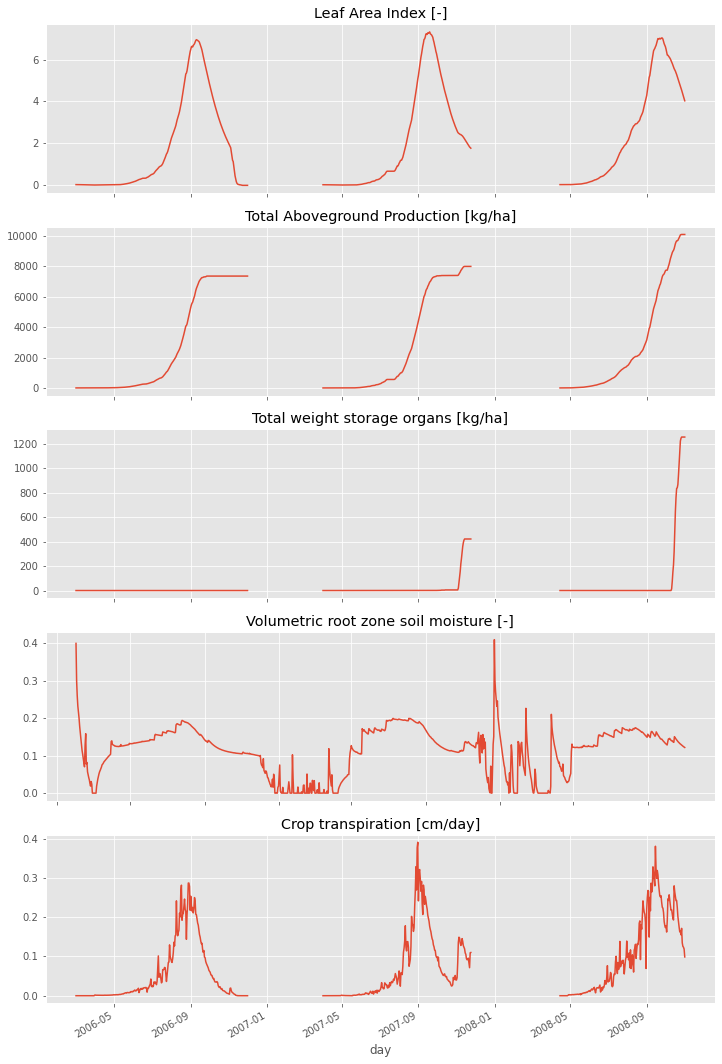

In [62]:
plot_variables = [("LAI", "Leaf Area Index [-]"), 
                  ("TAGP", "Total Aboveground Production [kg/ha]"), 
                  ("TWSO", "Total weight storage organs [kg/ha]"), 
                  ("SM", "Volumetric root zone soil moisture [-]"),
                  ("TRA","Crop transpiration [cm/day]")]
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12,20))
for (varname, vartitle), ax in zip(plot_variables, axes):
    df[varname].plot(ax=ax, title=vartitle)
fig.autofmt_xdate()